In [22]:
import sys
import os

import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler

sys.path.append('..')

from fwc2.model import S2SDEncoder
from fwc2.utils import tsne_scatter, tsne_scatter_anomaly

In [23]:
encoder = S2SDEncoder.load_from_checkpoint('../models/model_h256.ckpt')

C:\Users\client\Projects\PhD\FWC2L\.envs\Lib\site-packages\lightning\pytorch\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.5.0.post0, which is newer than your current Lightning version: v2.4.0
C:\Users\client\Projects\PhD\FWC2L\.envs\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [24]:
print(encoder)

S2SDEncoder(
  (loss_fn): SelfSupervisedLoss(
    (loss): NTXentLoss(
      (distance): CosineSimilarity()
      (reducer): MeanReducer()
    )
  )
  (encoder): LazyMLP(
    (model): Sequential(
      (0): Sequential(
        (0): LazyLinear(in_features=0, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): LinearLayer(
        (model): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
      )
    )
  )
  (projector): LazyMLP(
    (model): Sequential(
      (0): Sequential(
        (0): LazyLinear(in_features=0, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
  )
)


In [25]:
test_set = pd.read_csv('../data/dapt20/anomaly/test.csv')

In [26]:
features, labels = test_set.iloc[:,:-1], test_set['label']

In [27]:
features

,flow_duration,total_fwd_packet,total_bwd_packets,total_length_of_fwd_packet,total_length_of_bwd_packet,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,...,bwd_init_win_bytes,fwd_act_data_pkts,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
0,119764062,88,1,25515.0,289.0,296.0,288.0,289.943182,2.422870,289.0,...,-1,88,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0
1,232229,6,9,780.0,9272.0,355.0,0.0,130.000000,161.184366,5000.0,...,61,3,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0
2,5504166,2,2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,28960,0,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0
3,9422772,7,7,961.0,7528.0,326.0,0.0,137.285714,171.250999,4365.0,...,252,3,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0
4,119492722,89,1,25803.0,289.0,296.0,288.0,289.921348,2.417854,289.0,...,-1,89,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35716,110155456,17,10,107.0,343.0,21.0,0.0,6.294118,8.274696,54.0,...,227,8,26330.6,23524.999486,49975.0,827.0,22004546.0,1.095087e+07,30008639.0,10008379.0
35717,24089,1,1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,227,0,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0
35718,20106,1,1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,227,0,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0
35719,24091,1,1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,227,0,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0


In [28]:
features = StandardScaler().fit_transform(features)

In [29]:
features

array([[ 3.47453366, -0.02319458, -0.03235087, ..., -0.15758164,
        -0.24706813, -0.21116544],
       [-0.33158356, -0.03016089, -0.03118994, ..., -0.15758164,
        -0.24706813, -0.21116544],
       [-0.16371522, -0.03050071, -0.03220576, ..., -0.15758164,
        -0.24706813, -0.21116544],
       ...,
       [-0.33833795, -0.03058566, -0.03235087, ..., -0.15758164,
        -0.24706813, -0.21116544],
       [-0.33821106, -0.03058566, -0.03235087, ..., -0.15758164,
        -0.24706813, -0.21116544],
       [-0.33833977, -0.03058566, -0.03235087, ..., -0.15758164,
        -0.24706813, -0.21116544]])

In [30]:
labels.unique()

array(['benign', 'lateral movement', 'reconnaissance',
       'establish foothold', 'data exfiltration'], dtype=object)

In [31]:
embeddings = encoder.get_embeddings(torch.tensor(features, dtype=torch.float32))

In [32]:
embeddings.shape

torch.Size([35721, 256])

torch.Size([35721, 256]) , (35721,)
label
1    22979
0    12742
Name: count, dtype: int64


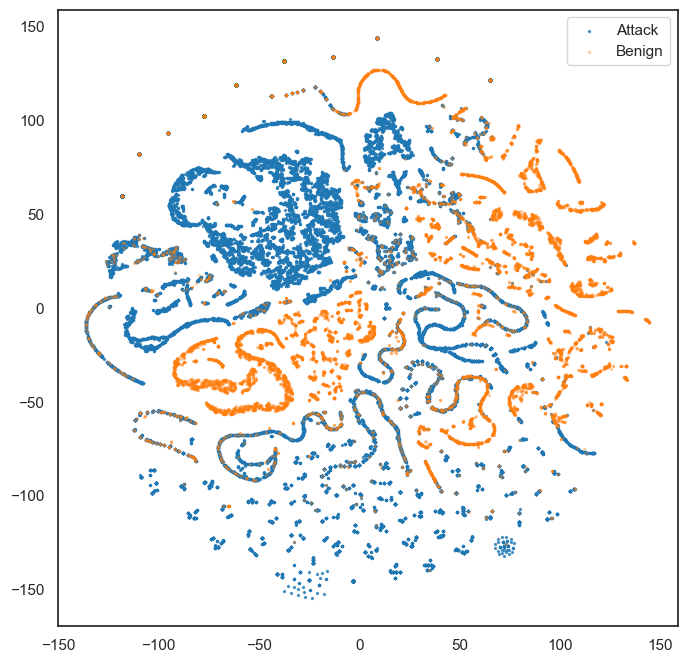

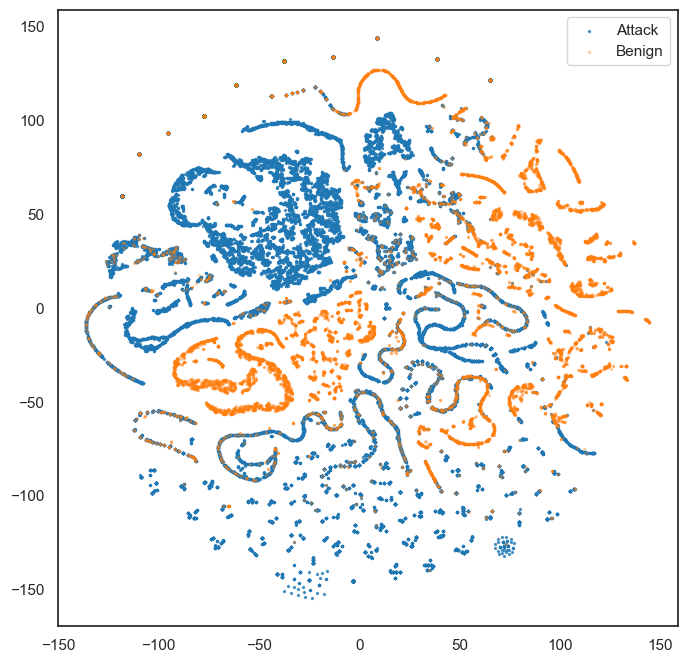

In [33]:
tsne_scatter_anomaly(embeddings, labels.apply(lambda l: 1 if l != 'benign' else 0))

(35721, 64) , (35721,)
label
1    22979
0    12742
Name: count, dtype: int64


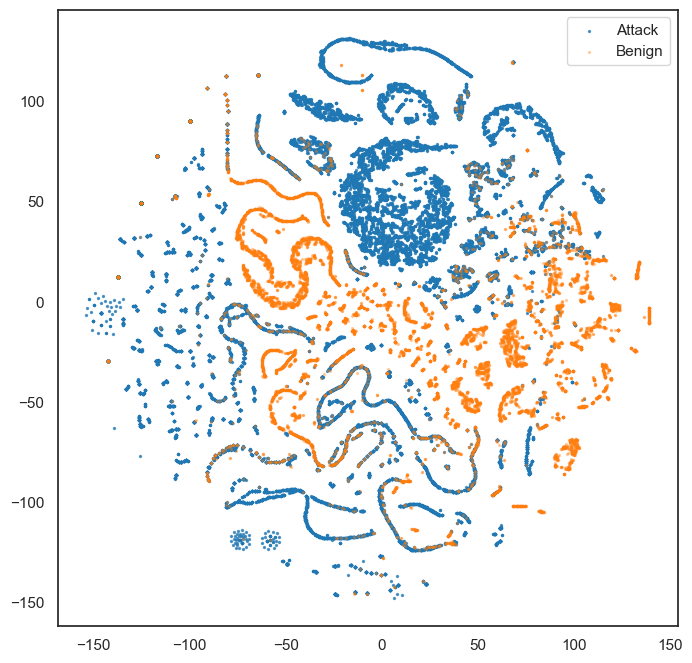

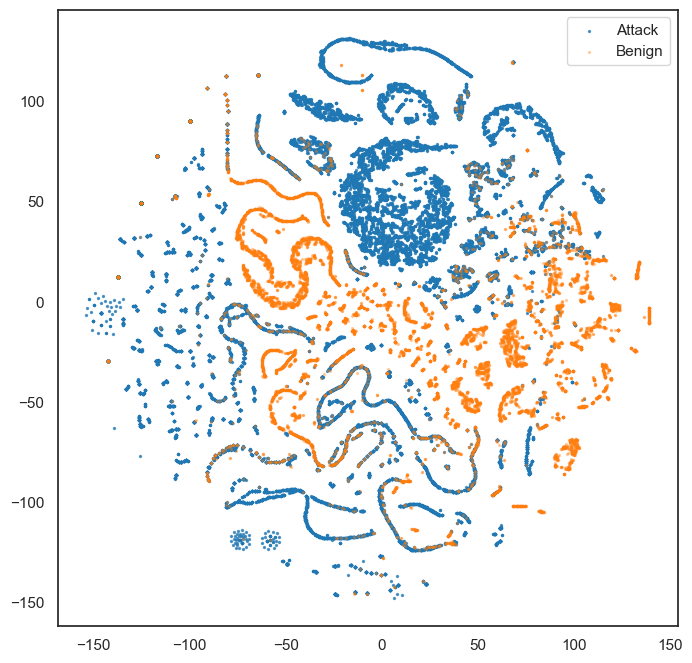

In [34]:
tsne_scatter_anomaly(features, labels.apply(lambda l: 1 if l != 'benign' else 0))


In [16]:
torch

<module 'torch' from 'C:\\Users\\client\\Projects\\PhD\\FWC2L\\.envs\\Lib\\site-packages\\torch\\__init__.py'>

In [17]:
from fwc2.model import RandomFeatureCorruption

In [18]:
x = torch.randn(5, 4)

In [19]:
x

tensor([[-0.3202,  1.4983,  1.0061,  2.7956],
        [-0.3262,  0.1791, -1.6430,  0.1069],
        [ 0.3372,  0.6628,  1.3475,  1.7656],
        [-1.0951, -2.1282,  0.9481,  0.6289],
        [-1.9872, -0.5045, -0.8545,  0.2227]])

In [20]:
mask = torch.rand_like(x, device=x.device) >= 0.9

In [21]:
mask

tensor([[False, False, False, False],
        [False, False, False, False],
        [False, False, False,  True],
        [False, False, False, False],
        [False, False, False, False]])